In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pe

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [3]:
'''
Loading
'''

atlas = nice.graph.graph_from_json('Data/atlas.json')
reduced_atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')
corridor_atlas = nice.graph.graph_from_json('Data/corridor_atlas.json')

state = gpd.read_file('Data/Geometry/california.shp')
counties = gpd.read_file('Data/Geometry/california_counties.shp')

graph_all = nice.graph.graph_from_json('Data/graph_100k.json')
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')
graph_nacs = nice.graph.graph_from_json('Data/graph_nacs_100k.json')

In [4]:
places = nice.graph.graph_from_json('Data/places_50k.json')

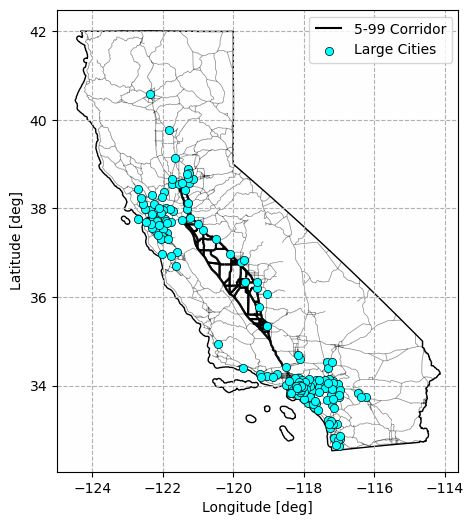

In [7]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'zorder': 0,
    'fc': 'none',
    'ec': 'k',
}

state.plot(ax = ax, **kw)


kw = {
    'plot': {
        'zorder': 1,
        'color': 'k',
        'lw': .5,
        'alpha': .25,
    },
}

_ = nice.plot.plot_edges(atlas, ax, **kw)

kw = {
    'plot': {
        'zorder': 2,
        'color': 'k',
        'lw': 1.5,
        'alpha': 1,
        'label': '5-99 Corridor',
    },
}

_ = nice.plot.plot_edges(corridor_atlas, ax, **kw)

kw = {
    'plot': {
        'zorder': 3,
        's': 35,
        'fc': 'xkcd:cyan',
        'ec': 'k',
        'lw': .5,
        'label': 'Large Cities',
    },
}

_ = nice.plot.plot_nodes(places, ax, **kw)

kw = {
    'xlabel': 'Longitude [deg]',
    'ylabel': 'Latitude [deg]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)

_ = ax.legend()

# fig.savefig(
#     'Paper/figures/places_corridor.png', bbox_inches = 'tight', dpi = 300
# )

In [13]:
ccs_stations = nice.graph.subgraph(
    graph_ccs, [k for k in graph_ccs.nodes if 'station' in k]
)

nacs_stations = nice.graph.subgraph(
    graph_nacs, [k for k in graph_nacs.nodes if 'station' in k]
)

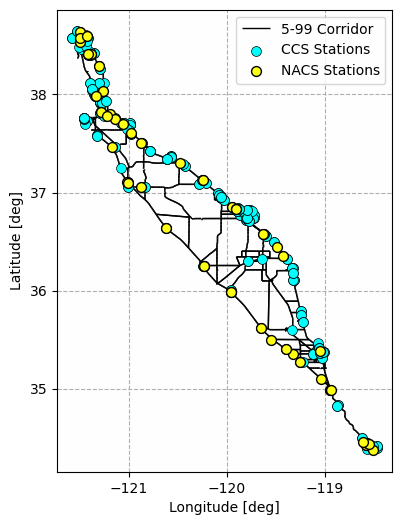

In [15]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'plot': {
        'zorder': 2,
        'color': 'k',
        'lw': 1,
        'alpha': 1,
        'label': '5-99 Corridor',
    },
}

_ = nice.plot.plot_edges(corridor_atlas, ax, **kw)

kw = {
    'plot': {
        'zorder': 3,
        's': 50,
        'fc': 'xkcd:cyan',
        'ec': 'k',
        'lw': .5,
        'label': 'CCS Stations',
    },
}

_ = nice.plot.plot_nodes(ccs_stations, ax, **kw)

kw = {
    'plot': {
        'zorder': 4,
        's': 50,
        'fc': 'xkcd:yellow',
        'ec': 'k',
        'lw': 1,
        'label': 'NACS Stations',
    },
}

_ = nice.plot.plot_nodes(nacs_stations, ax, **kw)

kw = {
    'xlabel': 'Longitude [deg]',
    'xticks': [-121, -120, -119],
    'ylabel': 'Latitude [deg]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)

_ = ax.legend()

ax.set_aspect('equal')

# fig.savefig(
#     'Paper/figures/places_corridor.png', bbox_inches = 'tight', dpi = 300
# )

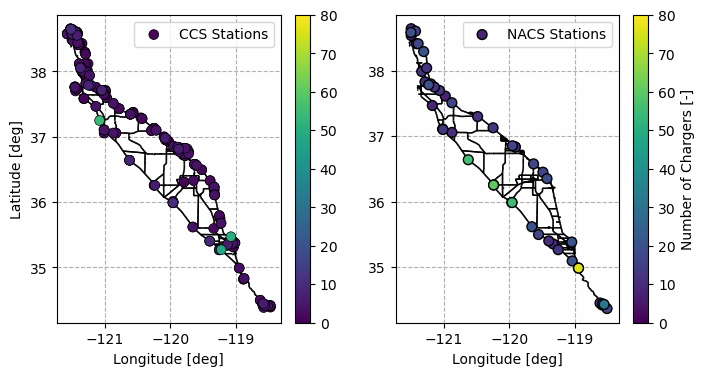

In [319]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

kw = {
    'plot': {
        'zorder': 2,
        'color': 'k',
        'lw': 1,
        'alpha': 1,
        # 'label': 'I5-CA99 Corridor',
    },
}

_ = nice.plot.plot_edges(corridor_atlas, ax[0], **kw)
_ = nice.plot.plot_edges(corridor_atlas, ax[1], **kw)

kw = {
    'field': 'port_count',
    'colorbar': {},
    'plot': {
        'zorder': 3,
        's': 50,
        'fc': 'xkcd:cyan',
        'ec': 'k',
        'lw': .5,
        'label': 'CCS Stations',
        'vmin': 0,
        'vmax': 80,
    },
}

_ = nice.plot.plot_nodes(ccs_stations, ax[0], **kw)

kw = {
    'field': 'port_count',
    'colorbar': {
        'label': 'Number of Chargers [-]',
    },
    'plot': {
        'zorder': 4,
        's': 50,
        'fc': 'xkcd:yellow',
        'ec': 'k',
        'lw': 1,
        'label': 'NACS Stations',
        'vmin': 0,
        'vmax': 80,
    },
}

_ = nice.plot.plot_nodes(nacs_stations, ax[1], **kw)

ax[0].set_ylabel('Latitude [deg]')

kw = {
    'xlabel': 'Longitude [deg]',
    'xticks': [-121, -120, -119],
    'facecolor': '#fefefe',
    # 'ylabel': 'Latitude [deg]',
}

_ = [ax.set(**kw) for ax in ax]

kw = {
    'ls': '--',
}

_ = [ax.grid(**kw) for ax in ax]

_ = [ax.legend() for ax in ax]

_ = [ax.set_aspect('equal') for ax in ax]

fig.savefig(
    'Paper/figures/stations_corridor.png', bbox_inches = 'tight', dpi = 300
)

In [265]:
ccs_stations.number_of_nodes(), nacs_stations.number_of_nodes()

(344, 47)

In [323]:
np.array([n['port_count'] for n in ccs_stations._node.values()]).sum()

1029

In [324]:
np.array([n['port_count'] for n in nacs_stations._node.values()]).sum()

901

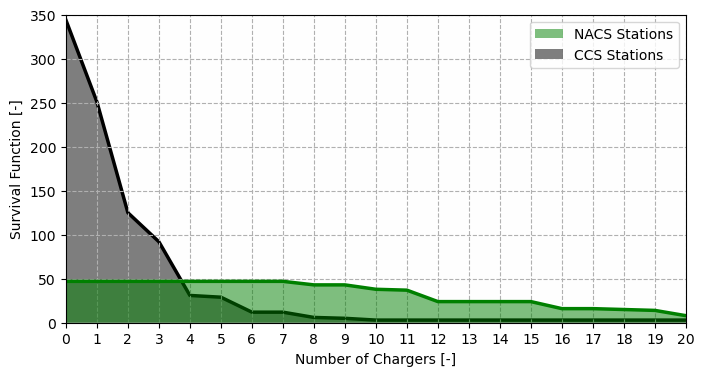

In [29]:
fig, ax = plt.subplots(figsize = (8, 4))

x = np.arange(0, 21, 1)
s = np.array([n['port_count'] for n in nacs_stations._node.values()])
y = np.array([sum(s > x) for x in x])

kw = {
    'lw': 2.5,
    'c': 'green',
    'zorder': 2,
}

ax.plot(x, y, **kw)

kw = {
    'fc': 'green',
    'alpha': .5,
    'label': 'NACS Stations',
    'zorder': 2,
}

ax.fill_between(x, y, **kw)

# x = np.arange(0, 41, 1)
s = np.array([n['port_count'] for n in ccs_stations._node.values()])
y = np.array([sum(s > x) for x in x])

kw = {
    'lw': 2.5,
    'c': 'k',
    'zorder': 1,
}

ax.plot(x, y, **kw)

kw = {
    'fc': 'k',
    'alpha': .5,
    'label': 'CCS Stations',
    'zorder': 1,
}

ax.fill_between(x, y, **kw)

kw = {
    'xlim': (0, max(x)),
    'ylim': (0, 350),
    'xticks': x,
    'xlabel': 'Number of Chargers [-]',
    'ylabel': 'Survival Function [-]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)
# 
_ = ax.legend()

fig.savefig(
    'Paper/figures/stations_survival.png', bbox_inches = 'tight', dpi = 300
)

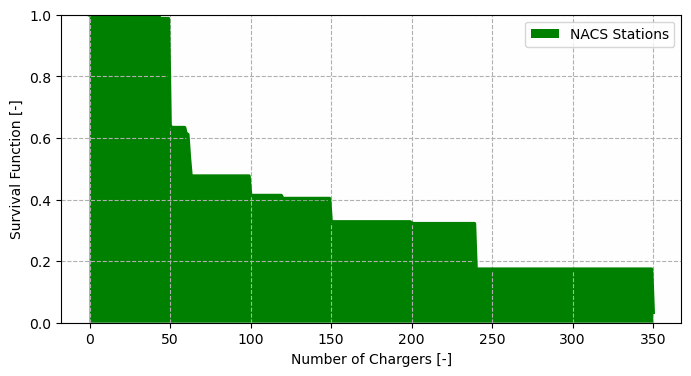

In [351]:
fig, ax = plt.subplots(figsize = (8, 4))

x = np.arange(0, 351, 1)
s = np.array(
    [n['power_kw'] for n in ccs_stations._node.values() for i in range(n['port_count'])]
    )
y = np.array([sum(s > x) / len(s) for x in x])

kw = {
    'lw': 2.5,
    'c': 'green',
}

ax.plot(x, y, **kw)

kw = {
    'fc': 'green',
    # 'alpha': .5,
    'label': 'NACS Stations',
}

ax.fill_between(x, y, **kw)

x = np.arange(0, 81, 1)
s = np.array([n['port_count'] for n in ccs_stations._node.values()])
y = np.array([sum(s > x) / len(s) for x in x])

kw = {
    'lw': 2.5,
    'c': 'k',
}

# ax.plot(x, y, **kw)

kw = {
    'fc': 'k',
    # 'alpha': .5,
    'label': 'CCS Stations',
}

# ax.fill_between(x, y, **kw)

kw = {
    # 'xlim': (0, 80),
    'ylim': (0, 1),
    'xlabel': 'Number of Chargers [-]',
    'ylabel': 'Survival Function [-]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)

_ = ax.legend()

# fig.savefig(
#     'Paper/figures/stations_survival.png', bbox_inches = 'tight', dpi = 300
# )

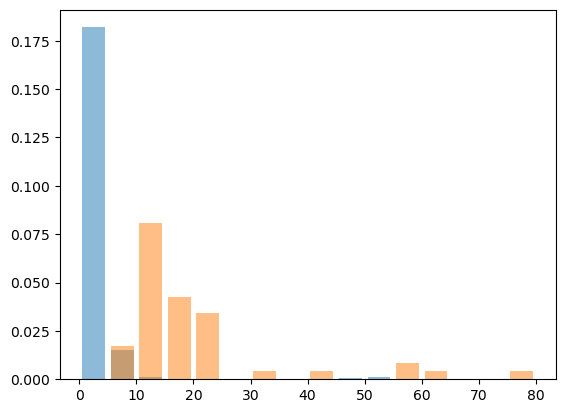

In [294]:
x = np.arange(0, 81, 5)
s_n = np.array([n['power_kw'] for n in nacs_stations._node.values()])
# y = np.array([sum(((s >= (xi - 5)) & (s < xi))) / len(s) for xi in x])

kw = {
    'bins': x,
    'density': True,
    'rwidth': .5,
}

# plt.hist(s, **kw)

x = np.arange(0, 81, 5)
s_c = np.array([n['power_kw'] for n in ccs_stations._node.values()])
# y = np.array([sum(((s >= (xi - 5)) & (s < xi))) / len(s) for xi in x])

kw = {
    'bins': x,
    'density': True,
    'rwidth': .8,
    'alpha': .5,
    # 'align': 'left',
}

_ = plt.hist(s_c, **kw)

kw = {
    'bins': x,
    'density': True,
    'rwidth': .8,
    'alpha': .5,
    # 'align': 'left',
}

_ = plt.hist(s_n, **kw)

In [74]:
'''
Loading results
'''

results = {}

results['CCS'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/ccs/summary_3.json', 'r')
)

results['NACS'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/nacs/summary_3.json', 'r')
)

results['Combined'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/all/summary_3.json', 'r')
)

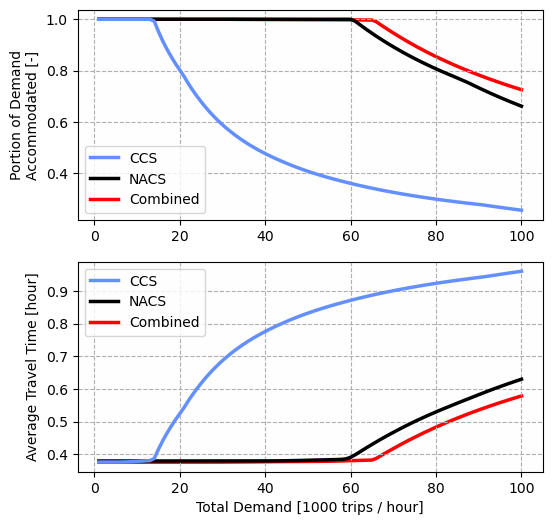

In [80]:
fig, ax = plt.subplots(2, 1, figsize = (6, 6))

# ax = [ax, ax.twinx()]

scales = np.array(results['NACS']['scales'])

max_cost = max([max(v['costs']) for v in results.values()])

colors = ["#1c4585", "#9b2ba1", "#1d8a20"]
colors = ["#4749dc", "#150c25", "#0a7fb2"]
colors = ["red", "k", "#648fff"]
linestyles = ['-.', '--', '-']
zorder = [1, 2, 3]

for k, v in results.items():

    kw = {
        'lw': 2.5,
        # 'ls': linestyles.pop(),
        'c': colors.pop(),
        'zorder': zorder.pop(),
        'label': f'{k}',
    }
    
    ax[0].plot(scales / 1e3, 1 - np.array(v['ratios']), **kw)
    ax[1].plot(
        scales / 1e3, (np.array(v['costs'])) / scales / 3600, **kw
    )

ax[0].set_ylabel('Portion of Demand\nAccommodated [-]')
ax[1].set_xlabel('Total Demand [1000 trips / hour]')
ax[1].set_ylabel('Average Travel Time [hour]')

kw = {
    # 'xlabel': 'Total Flow [1000 vehicles / hour]',
    'facecolor': '#fefefe',
    # 'xlim': [0, .5],
    # 'xlim': (0, 1e5),
}

_ = [ax.set(**kw) for ax in ax]

kw = {
    'ls': '--',
}

_ = [ax.grid(**kw) for ax in ax]

_ = [ax.legend() for ax in ax]

fig.savefig(
    'Paper/figures/esn_performance.png', bbox_inches = 'tight', dpi = 300
)

In [81]:
'''
Loading results
'''

results = {}

results['CCS'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/ccs/summary_3.json', 'r')
)

results['CCS +10'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/ccs_10u/summary_4.json', 'r')
)

results['CCS +25'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/ccs_25u/summary_4.json', 'r')
)

results['CCS +50'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/ccs_50u/summary_4.json', 'r')
)

results['CCS +100'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/ccs_100u/summary_4.json', 'r')
)

results['NACS'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/nacs/summary_3.json', 'r')
)

# results['All'] = json.load(
#     open('/media/aaron/Extreme SSD/nice_results/all/summary_3.json', 'r')
# )

# results['200'] = json.load(
#     open('/media/aaron/Extreme SSD/nice_results/ccs_200/summary_4.json', 'r')
# )

# results['300'] = json.load(
#     open('/media/aaron/Extreme SSD/nice_results/ccs_300/summary_4.json', 'r')
# )

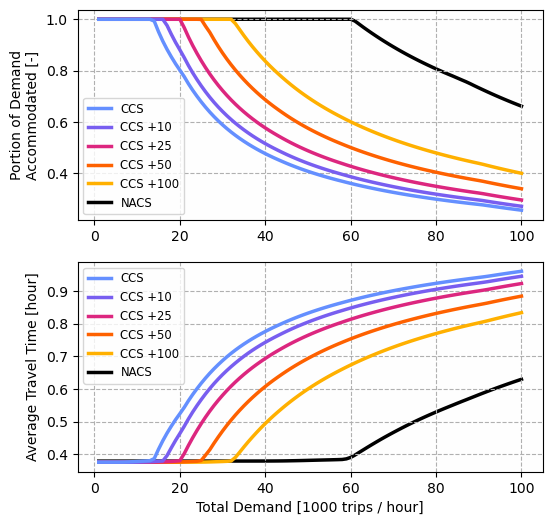

In [85]:
fig, ax = plt.subplots(2, 1, figsize = (6, 6))

# ax = [ax, ax.twinx()]

scales = np.array(results['NACS']['scales']) * 3600

max_cost = max([max(v['costs']) for v in results.values()])

colors = ["k", "#ffb000", "#fe6100", "#dc267f", "#785ef0", "#648fff"]
linestyles = ['-.', '--', '-', '-', '-', '-', '-',]
zorder = [1, 2, 3, 4, 5, 6]

for k, v in results.items():

    kw = {
        'lw': 2.5,
        # 'ls': linestyles.pop(),
        'c': colors.pop(),
        'zorder': zorder.pop(),
        'label': f'{k}',
    }
    
    ax[0].plot(scales / 1e3 / 3600, 1 - np.array(v['ratios']), **kw)
    ax[1].plot(
        scales / 1e3 / 3600, (np.array(v['costs'])) / scales, **kw
    )

ax[0].set_ylabel('Portion of Demand\nAccommodated [-]')
ax[1].set_xlabel('Total Demand [1000 trips / hour]')
ax[1].set_ylabel('Average Travel Time [hour]')

kw = {
    # 'xlabel': 'Total Flow [thousand veh / h]',
    'facecolor': '#fefefe',
    # 'xlim': [0, .5],
    # 'xlim': (0, 1e5),
}

_ = [ax.set(**kw) for ax in ax]

kw = {
    'ls': '--',
}

_ = [ax.grid(**kw) for ax in ax]

kw = {
    'fontsize': 'small',
}

_ = [ax.legend(**kw) for ax in ax]

fig.savefig(
    'Paper/figures/augmented_esn_performance.png',
    bbox_inches = 'tight', dpi = 300
)

In [60]:
graphs = {}

graphs['10'] = nice.graph.graph_from_json('Data/graph_ccs_10u.json')
graphs['25'] = nice.graph.graph_from_json('Data/graph_ccs_25u.json')
graphs['50'] = nice.graph.graph_from_json('Data/graph_ccs_50u.json')
graphs['100'] = nice.graph.graph_from_json('Data/graph_ccs_100u.json')

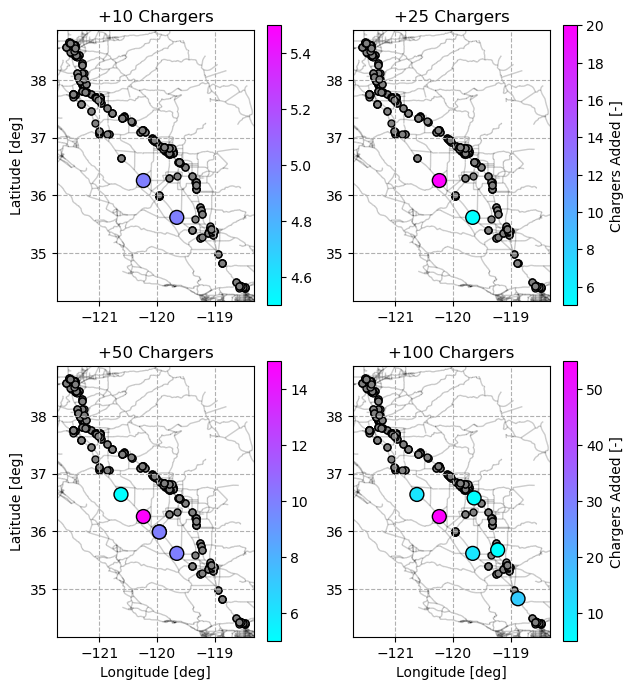

In [67]:
deep_reload(nice)

stations = [k for k, n in graphs['10']._node.items() if 'station' in k]

fig, ax = plt.subplots(2, 2, figsize = (7, 8))

kw = {
    'nodes': {
        'selection': stations,
        'plot': {
            's': 25,
            'zorder': 1,
            'ec': 'k',
            'fc': 'gray',
        },
    },
}
    
_ = [nice.plot.plot_graph(graphs['10'], ax = ax, **kw) for ax in ax for ax in ax]

stations = [k for k, n in graphs['10']._node.items() if 'station' in k]

kw = {
    'nodes': {
        'cmap': nice.plot.Colormap('cool'),
        'selection': [s for s in stations if graphs['10']._node[s]['delta'] > 0],
        'field': 'delta',
        'colorbar': {},
        'plot': {
            's': 100,
            'zorder': 2,
            'ec': 'k',
            # 'vmin': 0,
            # 'vmax': 70,
        },
    },
}
    
_ = nice.plot.plot_graph(graphs['10'], ax = ax[0, 0], **kw)

stations = [k for k, n in graphs['25']._node.items() if 'station' in k]

kw = {
    'nodes': {
        'cmap': nice.plot.Colormap('cool'),
        'selection': [s for s in stations if graphs['25']._node[s]['delta'] > 0],
        'field': 'delta',
        'colorbar': {
            'label': 'Chargers Added [-]',
        },
        'plot': {
            's': 100,
            'zorder': 2,
            'ec': 'k',
            # 'vmin': 0,
            # 'vmax': 70,
        },
    },
}
    
_ = nice.plot.plot_graph(graphs['25'], ax = ax[0, 1], **kw)

stations = [k for k, n in graphs['50']._node.items() if 'station' in k]

kw = {
    'nodes': {
        'cmap': nice.plot.Colormap('cool'),
        'selection': [s for s in stations if graphs['50']._node[s]['delta'] > 0],
        'field': 'delta',
        'colorbar': {},
        'plot': {
            's': 100,
            'zorder': 2,
            'ec': 'k',
            # 'vmin': 0,
            # 'vmax': 70,
        },
    },
}
    
_ = nice.plot.plot_graph(graphs['50'], ax = ax[1, 0], **kw)

stations = [k for k, n in graphs['100']._node.items() if 'station' in k]

kw = {
    'nodes': {
        'cmap': nice.plot.Colormap('cool'),
        'selection': [s for s in stations if graphs['100']._node[s]['delta'] > 0],
        'field': 'delta',
        'colorbar': {
            'label': 'Chargers Added [-]',
        },
        'plot': {
            's': 100,
            'zorder': 2,
            'ec': 'k',
            # 'vmin': 0,
            # 'vmax': 70,
        },
    },
}
    
_ = nice.plot.plot_graph(graphs['100'], ax = ax[1, 1], **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = [nice.plot.plot_graph(atlas, ax = ax, **kw) for ax in ax for ax in ax]

ax[0, 0].set_title('+10 Chargers')
ax[0, 1].set_title('+25 Chargers')
ax[1, 0].set_title('+50 Chargers')
ax[1, 1].set_title('+100 Chargers')

ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_xlabel('Longitude [deg]')
ax[1, 1].set_xlabel('Longitude [deg]')

kw = {
    'facecolor': '#fefefe',
}

_ = [ax.set(**kw) for ax in ax for ax in ax]

kw = {
    'ls': 'dashed',
}

_ = [ax.grid(**kw) for ax in ax for ax in ax]

_ = [ax.set_aspect('equal') for ax in ax for ax in ax]

fig.savefig(
    'Paper/figures/augmented_esns.png', bbox_inches = 'tight', dpi = 300
)

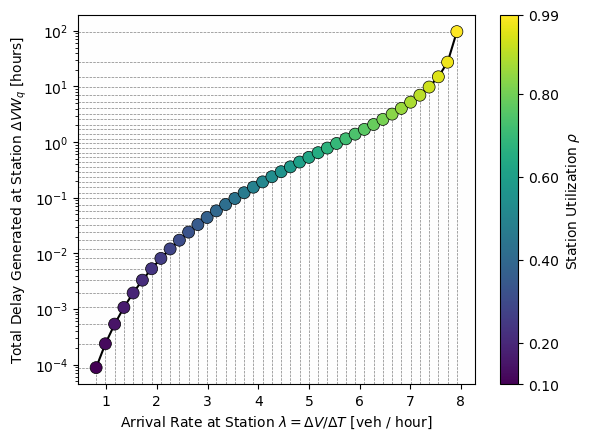

In [89]:
import matplotlib

energy = 40 * 3.6e6
rho = np.concatenate((np.linspace(.01, .5, 2), np.linspace(.51, .99, 20)))
rho = np.linspace(.1, .99, 40)
power = 80e3
m = 1 / (energy / power)
c = [4]
queue = nice.queue.Queue(m = m, rho = rho, c = c)

volumes = np.array(rho * m * c) * 3600
delays = (
    queue.interpolate(rho, c)[0] * rho * m * c * 3600 / (1 / volumes) / 3600 / 60
)
delays = queue.interpolate(rho, c)[0] / (1 / volumes) / 3600

cmap = nice.plot.Colormap()

fig, ax = plt.subplots()
ax.set_yscale('log')

kw = {
    'color': 'k',
    'lw': 1.5,
    'zorder': 0,
}

_ = ax.plot(volumes, delays, **kw)

kw = {
    'c': cmap(rho),
    's': 75,
    'ec': 'k',
    'lw': .5,
    'zorder': 2,
    'vmin': rho[0],
}

sm = ax.scatter(volumes, delays, **kw)

sm = matplotlib.cm.ScalarMappable(cmap = cmap.cmap, norm = cmap.norm)    
sm.set_array([])

kw = {
    'label': r'Station Utilization $\rho$',
    'ticks': [rho[0], .2, .4, .6, .8, rho[-1]],
}

colorbar = plt.colorbar(sm, ax = ax, **kw)

kw = {
    'color': 'gray',
    'lw': .5,
    'ls': '--',
    'zorder': 1,
}

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for idx in range(len(rho)):
    
    ax.plot([xlim[0], volumes[idx]], [delays[idx], delays[idx]], **kw)
    ax.plot([volumes[idx], volumes[idx]], [ylim[0], delays[idx]], **kw)

kw = {
    'xlim': xlim,
    'ylim': ylim,
    'facecolor': '#fefefe',
    'xlabel': r'Arrival Rate at Station $\lambda = \Delta V / \Delta T$ [veh / hour]',
    'ylabel': r'Total Delay Generated at Station $\Delta V W_q$ [hours]',
}

_ = ax.set(**kw)

fig.savefig(
    'Paper/figures/linearized_semilog.png', bbox_inches = 'tight', dpi = 300
)

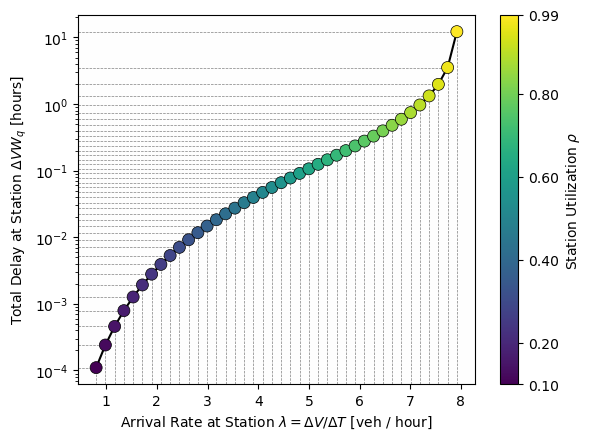

In [125]:
import matplotlib

energy = 40 * 3.6e6
rho = np.concatenate((np.linspace(.01, .5, 2), np.linspace(.51, .99, 20)))
rho = np.linspace(.1, .99, 40)
power = 80e3
m = 1 / (energy / power)
c = [4]
queue = nice.queue.Queue(m = m, rho = rho, c = c)

volumes = np.array(rho * m * c) * 3600
delays = (
    queue.interpolate(rho, c)[0] * rho * m * c * 3600 / (1 / volumes) / 3600 / 60
)
delays = queue.interpolate(rho, c)[0] / 3600

cmap = nice.plot.Colormap()

fig, ax = plt.subplots()
ax.set_yscale('log')

kw = {
    'color': 'k',
    'lw': 1.5,
    'zorder': 0,
}

_ = ax.plot(volumes, delays, **kw)

kw = {
    'c': cmap(rho),
    's': 75,
    'ec': 'k',
    'lw': .5,
    'zorder': 2,
    'vmin': rho[0],
}

sm = ax.scatter(volumes, delays, **kw)

sm = matplotlib.cm.ScalarMappable(cmap = cmap.cmap, norm = cmap.norm)    
sm.set_array([])

kw = {
    'label': r'Station Utilization $\rho$',
    'ticks': [rho[0], .2, .4, .6, .8, rho[-1]],
}

colorbar = plt.colorbar(sm, ax = ax, **kw)

kw = {
    'color': 'gray',
    'lw': .5,
    'ls': '--',
    'zorder': 1,
}

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for idx in range(len(rho)):
    
    ax.plot([xlim[0], volumes[idx]], [delays[idx], delays[idx]], **kw)
    ax.plot([volumes[idx], volumes[idx]], [ylim[0], delays[idx]], **kw)

kw = {
    'xlim': xlim,
    'ylim': ylim,
    'facecolor': '#fefefe',
    'xlabel': r'Arrival Rate at Station $\lambda = \Delta V / \Delta T$ [veh / hour]',
    'ylabel': r'Total Delay at Station $\Delta V W_q$ [hours]',
}

_ = ax.set(**kw)

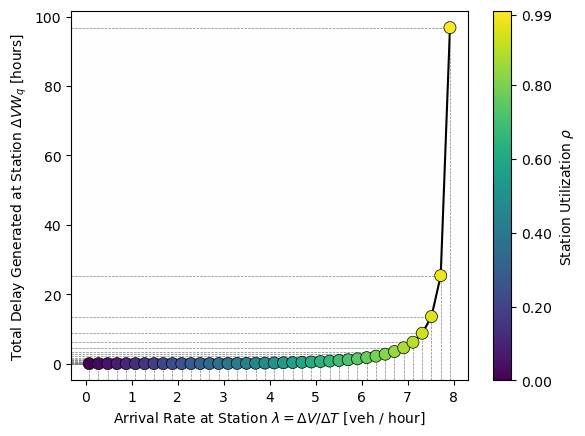

In [88]:
deep_reload(nice)
import matplotlib

energy = 40 * 3.6e6
rho = np.concatenate((np.linspace(.01, .5, 2), np.linspace(.51, .99, 20)))
rho = np.linspace(.01, .99, 40)
power = 80e3
m = 1 / (energy / power)
c = [4]
queue = nice.queue.Queue(m = m, rho = rho, c = c)

volumes = np.array(rho * m * c) * 3600
delays = (
    queue.interpolate(rho, c)[0] * rho * m * c * 3600 / (1 / volumes) / 3600 / 60
)
delays = queue.interpolate(rho, c)[0] / (1 / volumes) / 3600

cmap = nice.plot.Colormap()

fig, ax = plt.subplots()

kw = {
    'color': 'k',
    'lw': 1.5,
    'zorder': 0,
}

_ = ax.plot(volumes, delays, **kw)

kw = {
    'c': cmap(rho),
    's': 75,
    'ec': 'k',
    'lw': .5,
    'zorder': 2,
}

sm = ax.scatter(volumes, delays, **kw)

kw = {
    'label': r'Station Utilization $\rho$',
    'ticks': [0, .2, .4, .6, .8, .99],
}

colorbar = plt.colorbar(sm, ax = ax, **kw)

kw = {
    'color': 'gray',
    'lw': .5,
    'ls': '--',
    'zorder': 1,
}

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for idx in range(len(rho)):
    
    ax.plot([xlim[0], volumes[idx]], [delays[idx], delays[idx]], **kw)
    ax.plot([volumes[idx], volumes[idx]], [ylim[0], delays[idx]], **kw)

kw = {
    'xlim': xlim,
    'ylim': ylim,
    'facecolor': '#fefefe',
    'xlabel': r'Arrival Rate at Station $\lambda = \Delta V / \Delta T$ [veh / hour]',
    'ylabel': r'Total Delay Generated at Station $\Delta V W_q$ [hours]',
}

_ = ax.set(**kw)

fig.savefig(
    'Paper/figures/linearized.png', bbox_inches = 'tight', dpi = 300
)

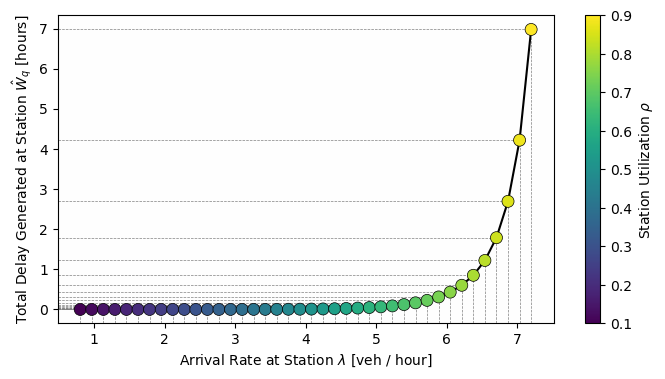

In [112]:
deep_reload(nice)
import matplotlib

energy = 40 * 3.6e6
# rho = np.concatenate((np.linspace(.01, .5, 2), np.linspace(.51, .9, 20)))
rho = np.linspace(.1, .9, 40)
power = 80e3
m = 1 / (energy / power)
c = [4]
queue = nice.queue.Queue(m = m, rho = rho, c = c)

volumes = np.array(rho * m * c) * 3600
# delays = (
#     queue.interpolate(rho, c)[0] * rho * m * c * 3600 / (1 / volumes) / 3600 / 60
# )
delays = queue.interpolate(rho, c)[0] / 3600

cmap = nice.plot.Colormap()

fig, ax = plt.subplots(figsize = (8, 4))

kw = {
    'color': 'k',
    'lw': 1.5,
    'zorder': 0,
}

_ = ax.plot(volumes, delays, **kw)

kw = {
    'c': cmap(rho),
    's': 75,
    'ec': 'k',
    'lw': .5,
    'zorder': 2,
}

sm = ax.scatter(volumes, delays, **kw)

kw = {
    'label': r'Station Utilization $\rho$',
    'ticks': np.linspace(rho[0], rho[-1], 9),
}

sm = matplotlib.cm.ScalarMappable(cmap = cmap.cmap, norm = cmap.norm)    
sm.set_array([])

colorbar = plt.colorbar(sm, ax = ax, **kw)

kw = {
    'color': 'gray',
    'lw': .5,
    'ls': '--',
    'zorder': 1,
}

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for idx in range(len(rho)):
    
    ax.plot([xlim[0], volumes[idx]], [delays[idx], delays[idx]], **kw)
    ax.plot([volumes[idx], volumes[idx]], [ylim[0], delays[idx]], **kw)

kw = {
    'xlim': xlim,
    'ylim': ylim,
    'facecolor': '#fefefe',
    'xlabel': r'Arrival Rate at Station $\lambda$ [veh / hour]',
    'ylabel': r'Total Delay Generated at Station $\hat{W}_q$ [hours]',
}

_ = ax.set(**kw)

fig.savefig(
    'Paper/figures/linearized.png', bbox_inches = 'tight', dpi = 300
)

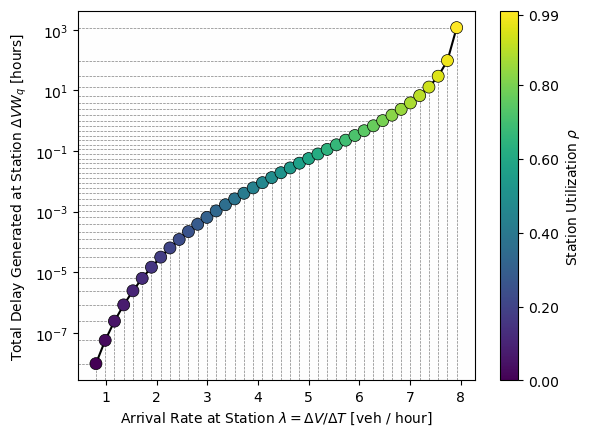

In [100]:
deep_reload(nice)
import matplotlib

energy = 40 * 3.6e6
# rho = np.concatenate((np.linspace(.01, .5, 2), np.linspace(.51, .9, 20)))
rho = np.linspace(.1, .99, 40)
power = 80e3
m = 1 / (energy / power)
c = [4]
queue = nice.queue.Queue(m = m, rho = rho, c = c)

volumes = np.array(rho * m * c) * 3600
# delays = (
#     queue.interpolate(rho, c)[0] * rho * m * c * 3600 / (1 / volumes) / 3600 / 60
# )
delays = queue.interpolate(rho, c)[0] / 3600

cmap = nice.plot.Colormap()

fig, ax = plt.subplots()
ax.set_yscale('log')

kw = {
    'color': 'k',
    'lw': 1.5,
    'zorder': 0,
}

_ = ax.plot(volumes, delays, **kw)

kw = {
    'c': cmap(rho),
    's': 75,
    'ec': 'k',
    'lw': .5,
    'zorder': 2,
}

sm = ax.scatter(volumes, delays, **kw)

kw = {
    'label': r'Station Utilization $\rho$',
    'ticks': [0, .2, .4, .6, .8, .99],
}

colorbar = plt.colorbar(sm, ax = ax, **kw)

kw = {
    'color': 'gray',
    'lw': .5,
    'ls': '--',
    'zorder': 1,
}

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for idx in range(len(rho)):
    
    ax.plot([xlim[0], volumes[idx]], [delays[idx], delays[idx]], **kw)
    ax.plot([volumes[idx], volumes[idx]], [ylim[0], delays[idx]], **kw)

kw = {
    'xlim': xlim,
    'ylim': ylim,
    'facecolor': '#fefefe',
    'xlabel': r'Arrival Rate at Station $\lambda = \Delta V / \Delta T$ [veh / hour]',
    'ylabel': r'Total Delay Generated at Station $\Delta V W_q$ [hours]',
}

_ = ax.set(**kw)

# fig.savefig(
#     'Paper/figures/linearized.png', bbox_inches = 'tight', dpi = 300
# )